# H. Restaurants

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils.matplotlib_init

In [2]:
df = pd.read_csv('input/h_train.txt', sep='\t', header=None)
df = df.replace(-1, np.nan)
df = df.fillna(np.nanmean(df[[1, 2]]))
print(df.shape)
df.head()

(1000, 5)


,0,1,2,3,4
0,0.5,8.154642,7.945215,0.000552,0.000483
1,1.0,7.945215,9.105132,0.075709,0.024765
2,0.0,7.349630,7.945215,0.045557,0.006901
3,0.0,7.077312,7.945215,0.000369,0.004083
4,1.0,7.945215,7.945215,0.002481,0.002171


If we plot distance and ratings distributions we might notice that there are a lot of small distances near zero and ratings are concentrated around 7-8. Logically, users might be much more sensitive to difference between 100 meters and 1 km than 100km and 101 km. On the contrary low ratings 2 or 3 are percieved as almost equally poor, while difference between 8 and 9 rating feels more important. In order to take this into account, we might try to apply log transformation to distances and exponential transformation to ratings. 

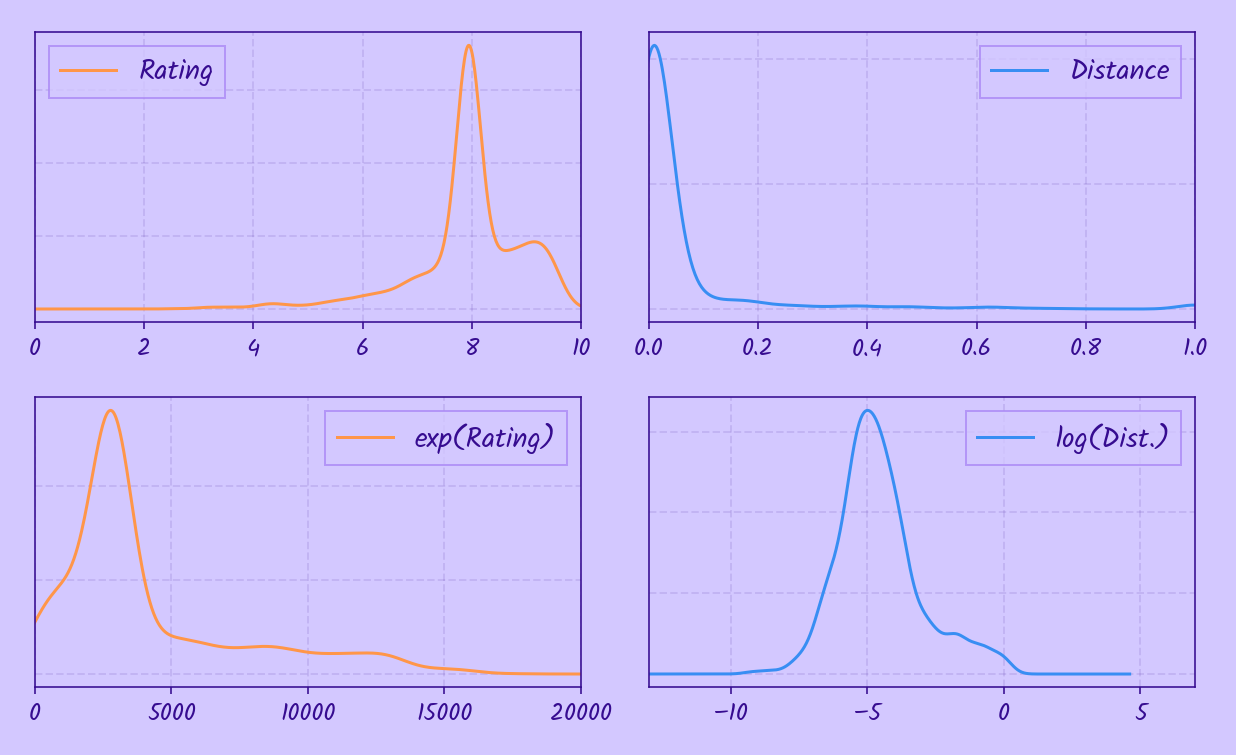

In [12]:
with plt.rc_context(rc={'legend.fontsize': 14, 'xtick.labelsize': 12, 'axes.grid': True}):
    plt.subplot(221)
    ax = df[[1, 2]].stack().plot(kind='kde', xlim=(0, 10), color='C1', label='Rating')
    ax.yaxis.label.set_visible(False)
    plt.tick_params(axis='y', labelleft=False, left=False)
    ax.legend()

    plt.subplot(223)
    ax = np.exp(df[[1, 2]]).stack().plot(kind='kde', xlim=(0, 20000), color='C1', label='exp(Rating)')
    ax.legend()
    ax.yaxis.label.set_visible(False)
    plt.tick_params(axis='y', labelleft=False, left=False)
    ax.legend()

    plt.subplot(222)
    ax = df[[3, 4]].stack().plot(kind='kde', xlim=(0, 1), label='Distance')
    ax.legend()
    ax.yaxis.label.set_visible(False)
    plt.tick_params(axis='y', labelleft=False, left=False)
    ax.legend()

    plt.subplot(224)
    ax = np.log(df[[3, 4]].stack() + 0.0001).plot(kind='kde', xlim=(-13, 7), label='log(Dist.)')
    ax.legend(loc='upper right')
    ax.yaxis.label.set_visible(False)
    plt.tick_params(axis='y', labelleft=False, left=False)
    ax.legend()
    
    plt.tight_layout(pad=1.5)
    plt.savefig('h.svg')

Let's prepare some features based on our observations:

In [4]:
df['d1'] = np.log(df[3] + 0.0001)
df['d2'] = np.log(df[4] + 0.0001)
df['r1'] = np.exp(df[1])
df['r2'] = np.exp(df[2])
r_mean = df[[1, 2]].values.mean()
r_exp_mean = df[['r1', 'r2']].values.mean()
r_exp_std = df[['r1', 'r2']].values.std()
d_log_mean = df[['d1', 'd2']].values.mean()
d_log_std = df[['d1', 'd2']].values.std()
df['r1'], df['r2'] = (df['r1'] - r_exp_mean) / r_exp_std, (df['r2'] - r_exp_mean) / r_exp_std
df['d1'], df['d2'] = (df['d1'] - d_log_mean) / d_log_std, (df['d2'] - d_log_mean) / d_log_std
df['r_diff'] = df['r1'] - df['r2']
df['d_diff'] = df['d1'] - df['d2']

Actually, at first I tried to use original features without those transformations but the results were worse.

We will use a simple linear model to predict restaurant scores based on distance and rating:

$$score_i=w_1 r_i + w_2 d_i$$

We would like scores to be such that:

$$
\sigma(score_i - score_j) = \sigma (  w_1(r_i-r_j) + w_2(d_i-d_j)) =
\begin{cases}
0 & \text{ if restaurant } \textit{ j } \text{ is winner  } \\ 
1 & \text{ if restaurant } \textit{ i } \text{ is winner  } \\ 
\end{cases}
$$

Were $\sigma(x) = \frac{1}{1 + e^{-x}}$ - is sigmoid fuction.

This formulation is equivalent to solving logistic regression that minimizes negative log likelihood - the expression used for performance evaluation in the task:

$$\frac{1}{N}\sum_{k=1}^{N}\ln(1+e^{score_{looser_k} - score_{winner_k}}))$$

So we can write simple iterative algorithm to find those weights based on our data (ignoring target=0.5):

In [5]:
df_without_ties = df[df[0] != 0.5]
w = np.zeros(2)
x = df_without_ties[['r_diff', 'd_diff']].values
y = 1 - df_without_ties[0].values
v = np.zeros_like(w)
for i in range(10000):
    z = w @ x.T
    h = 1 / (1 + np.exp(-z))
    gradient = x.T @ (h - y) / x.shape[0]
    v = 0.9 * v + 0.01 * gradient
    w -= v

print('W =', w)

W = [ 0.72500236 -1.94289503]


Let's calculate scores

In [6]:
df['s1'] = df[['r1', 'd1']] @ w
df['s2'] = df[['r2', 'd2']] @ w
df['s_diff'] = df['s1'] - df['s2']

The target metric on train data would be:

In [7]:
pd.concat((np.log(1 + np.exp(df[df[0] == 0]['s2'] - df[df[0] == 0]['s1'])), 
           np.log(1 + np.exp(df[df[0] == 1]['s1'] - df[df[0] == 1]['s2'])))).mean()

0.5591202146966274

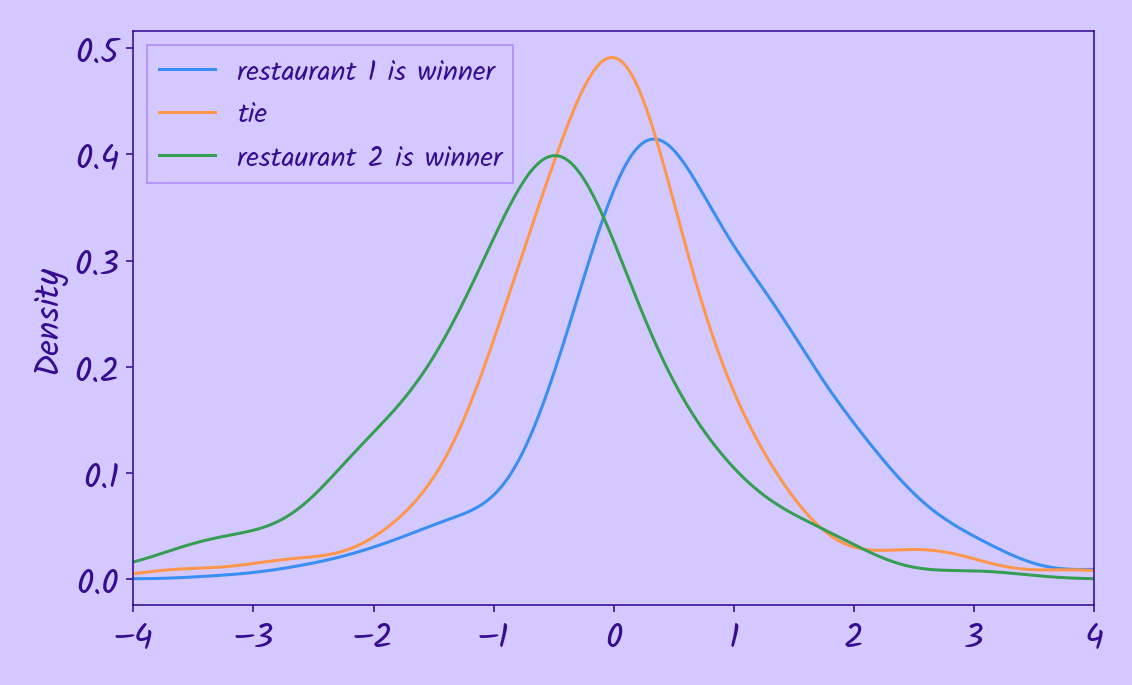

In [8]:
ax = df[[0, 's_diff']].groupby(0)['s_diff'].plot(kind='kde', xlim=(-4, 4))
ax[0].legend(('restaurant 1 is winner', 'tie', 'restaurant 2 is winner'), loc='upper left', fontsize=14);

Now we can use obtained coefficients for linear model to predict scores in test data. See `h.py` for details.